In [1]:
%load_ext autoreload
%autoreload 2

# Training

In [2]:
import sys
from pathlib import Path

sys.path.insert(0, "/home/saxelrod/Repo/projects/dimenet_nff/NeuralForceField")

import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader

from nff.data import Dataset, split_train_validation_test, collate_dicts, to_tensor
from nff.train import Trainer, get_trainer, get_model, load_model, loss, hooks, metrics, evaluate

In [3]:

modelparams = {"n_rbf": 6,
               "cutoff": 5.0,
               "envelope_p": 5,
               "n_spher": 6,
               "l_spher": 7,
               "atom_embed_dim": 128,
               "n_bilinear": 8,
               "activation": "swish",
               "n_convolutions": 6,
               "output_keys": ["energy"],
               "grad_keys": ["energy_grad"]}

model = get_model(modelparams, model_type="DimeNet")


Import data

In [4]:
DEVICE = 3
OUTDIR = './sandbox'
BATCH_SIZE = 25

if os.path.exists(OUTDIR):
    newpath = os.path.join(os.path.dirname(OUTDIR), 'backup')
    if os.path.exists(newpath):
        shutil.rmtree(newpath)
        
    shutil.move(OUTDIR, newpath)
    
dataset = Dataset.from_file('./data/dataset.pth.tar')

Generate angle list

In [5]:
_ = dataset.generate_angle_list()

Make trainer

In [6]:
train, val, test = split_train_validation_test(dataset, val_size=0.2, test_size=0.2)

train_loader = DataLoader(train, batch_size=BATCH_SIZE, collate_fn=collate_dicts)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, collate_fn=collate_dicts)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, collate_fn=collate_dicts)

loss_fn = loss.build_mse_loss(loss_coef={'energy': 0.01, 'energy_grad': 1})
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = Adam(trainable_params, lr=3e-4)

train_metrics = [
    metrics.MeanAbsoluteError('energy'),
    metrics.MeanAbsoluteError('energy_grad')
]


train_hooks = [
    hooks.MaxEpochHook(100),
    hooks.CSVHook(
        OUTDIR,
        metrics=train_metrics,
    ),
    hooks.PrintingHook(
        OUTDIR,
        metrics=train_metrics,
        separator = ' | ',
        time_strf='%M:%S'
    ),
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer,
        patience=30,
        factor=0.5,
        min_lr=1e-7,
        window_length=1,
        stop_after_min=True
    )
]

T = Trainer(
    model_path=OUTDIR,
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_loader=train_loader,
    validation_loader=val_loader,
    checkpoint_interval=1,
    hooks=train_hooks
)

Train

In [7]:
T.train(device=DEVICE, n_epochs=100)

 Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy | MAE_energy_grad | GPU Memory (MB)
39:36 |     1 |     3.000e-04 |   453.3691 |        228.9415 |    27.6159 |         10.0350 |               0
39:41 |     2 |     3.000e-04 |   179.8812 |        129.4151 |     2.8185 |          7.5710 |               0
39:46 |     3 |     3.000e-04 |    71.3767 |         46.1018 |     5.8234 |          5.0199 |               0
39:51 |     4 |     3.000e-04 |    37.5111 |         31.9273 |     6.8657 |          4.1487 |               0
39:56 |     5 |     3.000e-04 |    27.2760 |         25.3626 |     4.0609 |          3.7167 |               0
40:01 |     6 |     3.000e-04 |    22.3125 |         21.4536 |     3.7601 |          3.4261 |               0
40:06 |     7 |     3.000e-04 |    19.0661 |         18.1167 |     2.3226 |          3.1447 |               0
40:11 |     8 |     3.000e-04 |    16.7133 |         15.8197 |     2.1555 |          2.9277 |               0
40:17 |   

45:54 |    75 |     3.000e-04 |     1.5299 |          1.9991 |     1.3663 |          1.0086 |               0
45:59 |    76 |     3.000e-04 |     1.5136 |          1.9792 |     1.4627 |          1.0010 |               0
46:03 |    77 |     3.000e-04 |     1.4916 |          1.9789 |     1.5781 |          0.9978 |               0
46:08 |    78 |     3.000e-04 |     1.4729 |          2.0578 |     1.7921 |          1.0142 |               0
46:13 |    79 |     3.000e-04 |     1.4930 |          2.3458 |     2.1875 |          1.0812 |               0
46:18 |    80 |     3.000e-04 |     1.6579 |          1.9940 |     1.8369 |          1.0091 |               0
46:22 |    81 |     3.000e-04 |     1.9175 |          1.7977 |     0.3674 |          0.9728 |               0
46:27 |    82 |     3.000e-04 |     1.5246 |          1.8323 |     0.5840 |          0.9928 |               0
46:32 |    83 |     3.000e-04 |     2.1045 |          2.8652 |     2.5871 |          1.2270 |               0
46:36 |   

# Evaluating on the test set

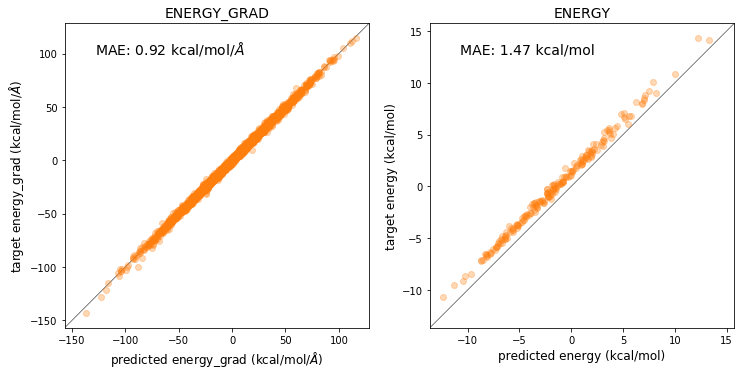

In [49]:
results, targets, val_loss = evaluate(T.get_best_model(), test_loader, loss_fn, device=DEVICE)


units = {
    'energy_grad': r'kcal/mol/$\AA$',
    'energy': 'kcal/mol'
}

fig, ax_fig = plt.subplots(1, 2, figsize=(12, 6))

for ax, key in zip(ax_fig, units.keys()):
    pred = torch.stack(results[key], dim=0).view(-1).detach().cpu().numpy()
    targ = torch.stack(targets[key], dim=0).view(-1).detach().cpu().numpy()
    mae = abs(pred-targ).mean()
    
    ax.scatter(pred, targ, color='#ff7f0e', alpha=0.3)
    
    lim_min = min(np.min(pred), np.min(targ)) * 1.1
    lim_max = max(np.max(pred), np.max(targ)) * 1.1
    
    ax.set_xlim(lim_min, lim_max)
    ax.set_ylim(lim_min, lim_max)
    ax.set_aspect('equal')
    
    ax.plot((lim_min, lim_max),
            (lim_min, lim_max),
            color='#000000',
            zorder=-1,
            linewidth=0.5)
    
    ax.set_title(key.upper(), fontsize=14)
    ax.set_xlabel('predicted %s (%s)' % (key, units[key]), fontsize=12)
    ax.set_ylabel('target %s (%s)' % (key, units[key]), fontsize=12)
    ax.text(0.1, 0.9, 'MAE: %.2f %s' % (mae, units[key]), 
           transform=ax.transAxes, fontsize=14)

plt.show()

# For fun: visualizing the basis functions

In [22]:
from nff.nn.layers import Envelope

envelope_p = 5
envelope = Envelope(envelope_p)

Layers with and without envelope function

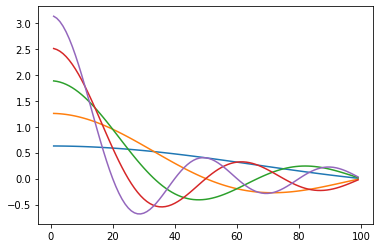

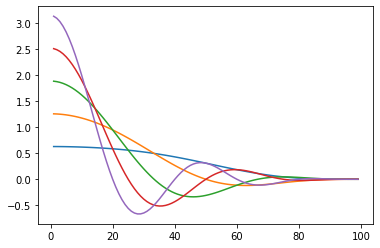

In [23]:


cutoff = 5.0

n_rbf = 5
d = torch.arange(0, cutoff, 0.05).reshape(-1, 1)
n = torch.arange(1, n_rbf + 1).float()
k_n = n * np.pi / cutoff
env = envelope(d / 5)

arg = torch.sin(k_n * d) / d
plt.plot(arg)
plt.show()

plt.plot(arg *env)
plt.show()

Layers without envelope function, directly from module

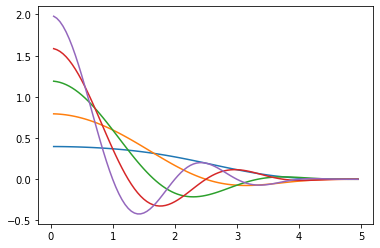

In [24]:
from nff.nn.layers import DimeNetRadialBasis, DimeNetSphericalBasis

dime_rbf = DimeNetRadialBasis(n_rbf=n_rbf,
                 cutoff=cutoff,
                 envelope_p=envelope_p)
out = dime_rbf(d)
plt.plot(d, out.detach().numpy())
plt.show()

Spherical basis functions

In [25]:
n_spher = 4
l_spher = 4
dime_sbf = DimeNetSphericalBasis(l_spher=l_spher,
                 n_spher=n_spher,
                 cutoff=5.0,
                 envelope_p=6)

In [26]:
self = dime_sbf

pos_x = torch.arange(0.05, self.cutoff * 1.2, 0.05)
neg_x = torch.arange(-self.cutoff * 1.2, -0.05, 0.05)

x = torch.cat([neg_x, pos_x])
y = torch.cat([neg_x, pos_x])


xv, yv = np.meshgrid(x, y)
xv = torch.Tensor(xv)
yv = torch.Tensor(yv)
                     
angles = torch.atan2(input=xv, other=yv)
d = (xv ** 2 + yv ** 2) ** 0.5

d_scaled = d / self.cutoff
rbf = [f(d_scaled) for f in self.bessel_funcs]
rbf = torch.stack(rbf, dim=1)

u = self.envelope(d_scaled)
cbf = [f(angles) for f in self.sph_funcs]
cbf = torch.stack(cbf, dim=1)


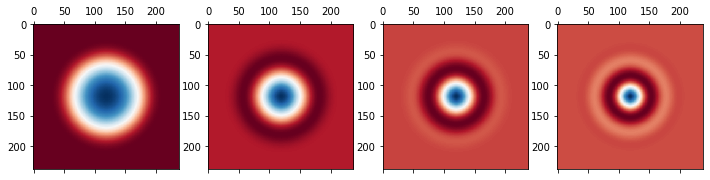

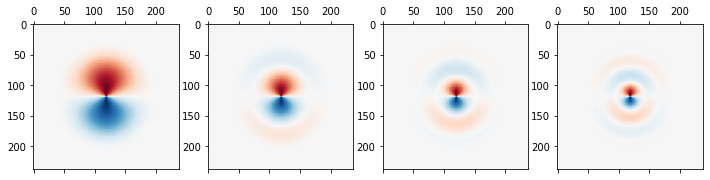

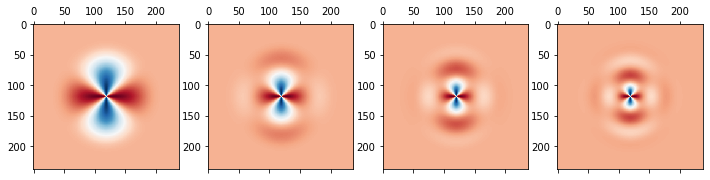

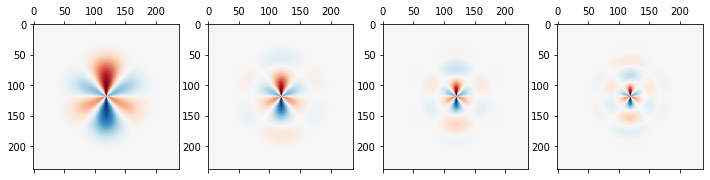

In [27]:
import matplotlib as mpl
cmap = mpl.colors.ListedColormap(['blue', 'red'])
bounds = [1, 2, 4, 7, 8]

for l in range(l_spher):
    totals = []
    for n in range(n_spher):
        total = cbf[:, l, :] * rbf[:, n, :] * u
        mask = np.heaviside(cutoff - d, 0)
        totals.append(total * mask)
        
    fig, ax_fig = plt.subplots(1, n_spher, figsize=(12, 6))

    
    for i, ax in enumerate(ax_fig):
        ax.matshow(totals[i].numpy(), cmap='RdBu')
